In [1]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

## Ontonotes NER detection performance

In [2]:
ONTO_RESULTS_DIR = Path('ontonotes')
summary= pd.read_csv(ONTO_RESULTS_DIR / 'summary_test.txt', sep='\t')

Check which models did not work, and exclude them from further analysis:

In [3]:
bad_performers = summary.loc[summary['F1-Macro'] < 0.1, 'Model']
bad_performers.tolist()

['finbert-char-ner', 'glove-char-ner']

In [4]:
summary = summary[~pd.isnull(summary['F1-Macro']) & (summary['F1-Macro'] > 0.1)]   # Skip bad performers
summary['Time'] = pd.to_datetime(summary['Ended']) - pd.to_datetime(summary['Started'])
summary['Time'] = np.round(summary['Time']/ np.timedelta64(1, 'h'), 1)
summary.sort_values(by='F1-Macro', ascending=False)

Model                  Started                    Ended  \
5      roberta-ner  2021-04-24 12:13:31,329  2021-04-24 21:33:39,196   
7        xlnet-ner  2021-04-24 21:33:39,245  2021-04-25 05:40:34,258   
0         elmo-ner  2021-04-23 21:32:41,683  2021-04-24 06:29:50,885   
6  xlm-roberta-ner  2021-04-25 05:40:34,354  2021-04-25 16:11:36,705   
2      finbert-ner  2021-04-24 22:36:57,340  2021-04-25 08:42:59,485   

   F1-Micro  F1-Macro  Time  
5    0.8657    0.7685   9.3  
7    0.8522    0.7559   8.1  
0    0.8515    0.7507   9.0  
6    0.8462    0.7318  10.5  
2    0.7950    0.6663  10.1

In [5]:
perf = pd.read_csv(ONTO_RESULTS_DIR / 'perf.txt', sep='\t', header=None)
perf.columns = ['Model', 'Type', 'Result']

In [6]:
def parse_number(str_, fun=int):
    try:
        return fun(str_)
    except ValueError:
        return None

def extract_metrics(entry):
    entry = entry['Result']
    match = re.search('tp: (\d+) - fp: (\d+) - fn: (\d+) - precision: (.*) - recall: (.*) - f1-score: (.*)', entry)
    if match:
        return (parse_number(match.group(1)), parse_number(match.group(2)), parse_number(match.group(3)),
                parse_number(match.group(4), fun=float), parse_number(match.group(5), fun=float),
                parse_number(match.group(6), fun=float))
    else:
        return (tuple([None]*6))

In [7]:
perf[['TP', 'FP', 'FN', 'Precision', 'Recall', 'F1-Score']] = perf[['Result']].apply(extract_metrics, axis=1, result_type="expand")
perf = perf.drop(labels='Result', axis=1)

In [8]:
perf.loc[~perf['Model'].isin(bad_performers), ['Model', 'Type', 'Precision', 'F1-Score']].pivot(index='Type', columns='Model')
# perf[['Model', 'Type', 'Precision', 'F1-Score']].pivot(index='Type', columns='Model')

Precision                                                     \
Model       bert-char-ner bert-glove-ner bert-ner elmo-ner finbert-glove-ner   
Type                                                                           
CARDINAL           0.0037         0.0000   0.7629   0.7754            0.0062   
DATE               0.0105         0.0000   0.7968   0.7896            0.0015   
EVENT              0.0000         0.0000   0.5349   0.5682            0.0000   
FAC                0.0000         0.0000   0.6822   0.6903            0.0000   
GPE                0.0057         0.0231   0.8826   0.8875            0.0088   
LANGUAGE           0.0000         0.0000   0.9000   0.8000            0.0000   
LAW                0.0000         0.0000   0.5814   0.5111            0.0000   
LOC                0.0000         0.0000   0.6157   0.6770            0.0000   
MONEY              0.0000         0.0000   0.8753   0.8691            0.0000   
NORP               0.0000         0.0007   0.8190   0.8668            0.0060   
ORDINAL            0.0000         0.0000   0.6519   0.6867            0.0000   
ORG                0.0007         0.0010   0.7997   0.8412            0.0062   
PERCENT            0.0000         0.0000   0.8605   0.8643            0.0000   
PERSON             0.0207         0.0034   0.8805   0.8853            0.0082   
PRODUCT            0.0000         0.0000   0.6479   0.7105            0.0000   
QUANTITY           0.0000         0.0000   0.7361   0.7557            0.0000   
TIME               0.0000         0.0000   0.5802   0.5982            0.0000   
WORK_OF_ART        0.0028         0.0000   0.6855   0.7343            0.0032   

                                                                             \
Model       finbert-ner finbert-roberta-ner flair-ner roberta-ner xlnet-ner   
Type                                                                          
CARDINAL         0.7413              0.0016    0.7655      0.7703    0.7471   
DATE             0.7663              0.0000    0.7969      0.7882    0.7838   
EVENT            0.4930              0.0000    0.5281      0.6163    0.6145   
FAC              0.5269              0.0000    0.7075      0.6406    0.6981   
GPE              0.8521              0.0005    0.8911      0.8897    0.8927   
LANGUAGE         0.5556              0.0000    0.8889      0.7778    0.5385   
LAW              0.4231              0.0000    0.6053      0.4348    0.5897   
LOC              0.6268              0.0000    0.7212      0.6352    0.6883   
MONEY            0.8575              0.0000    0.8618      0.8568    0.8611   
NORP             0.7834              0.0000    0.8570      0.8176    0.8792   
ORDINAL          0.5946              0.0000    0.6914      0.6838    0.6838   
ORG              0.7583              0.0023    0.8235      0.8250    0.8161   
PERCENT          0.8507              0.0000    0.8623      0.8491    0.8561   
PERSON           0.8155              0.0122    0.8660      0.8660    0.8431   
PRODUCT          0.7442              0.0000    0.7313      0.6667    0.6393   
QUANTITY         0.7073              0.0000    0.7597      0.7381    0.7687   
TIME             0.5391              0.0000    0.6056      0.6396    0.6000   
WORK_OF_ART      0.6596              0.0051    0.6429      0.6842    0.5507   

                 F1-Score                                                     \
Model       bert-char-ner bert-glove-ner bert-ner elmo-ner finbert-glove-ner   
Type                                                                           
CARDINAL           0.0039         0.0000   0.8059   0.7998            0.0031   
DATE               0.0021         0.0000   0.8461   0.8278            0.0016   
EVENT              0.0000         0.0000   0.5380   0.5780            0.0000   
FAC                0.0000         0.0000   0.6400   0.6023            0.0000   
GPE                0.0007         0.0085   0.9101   0.9139            0.0088   
LANGUAGE           0.0000         0

## Training performance (Ontonotes)

In [9]:
loss = pd.read_csv(ONTO_RESULTS_DIR / 'loss.txt', sep='\t')

In [10]:
loss = loss[~loss['MODEL'].isin(bad_performers)]
loss.head()

MODEL  EPOCH TIMESTAMP  BAD_EPOCHS  LEARNING_RATE  TRAIN_LOSS  \
0  bert-char-ner      1  11:17:10           0            0.1    3.253490   
1  bert-char-ner      2  11:34:08           0            0.1    2.438275   
2  bert-char-ner      3  11:51:16           1            0.1    2.082919   
3  bert-char-ner      4  12:08:26           0            0.1    1.925238   
4  bert-char-ner      5  12:25:36           0            0.1    1.824134   

    DEV_LOSS  DEV_PRECISION  DEV_RECALL  DEV_F1  
0  21.255554         0.0000      0.0000  0.0000  
1   1.626234         0.8371      0.8138  0.8253  
2   1.828509         0.7916      0.8595  0.8242  
3   1.541808         0.8163      0.8625  0.8387  
4   1.477503         0.8210      0.8629  0.8414

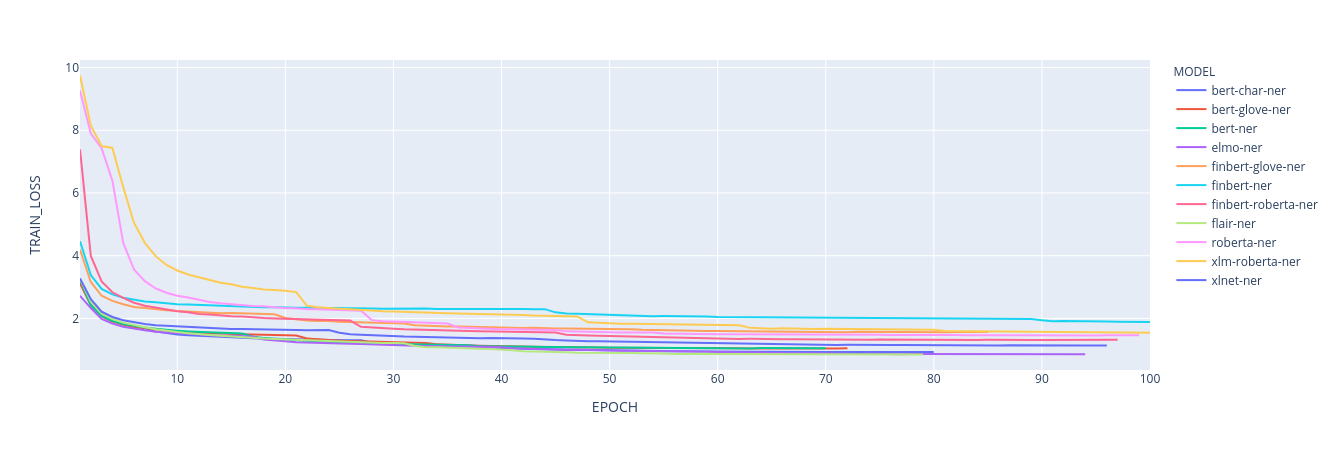

In [11]:
px.line(loss, x="EPOCH", y="TRAIN_LOSS", color='MODEL')

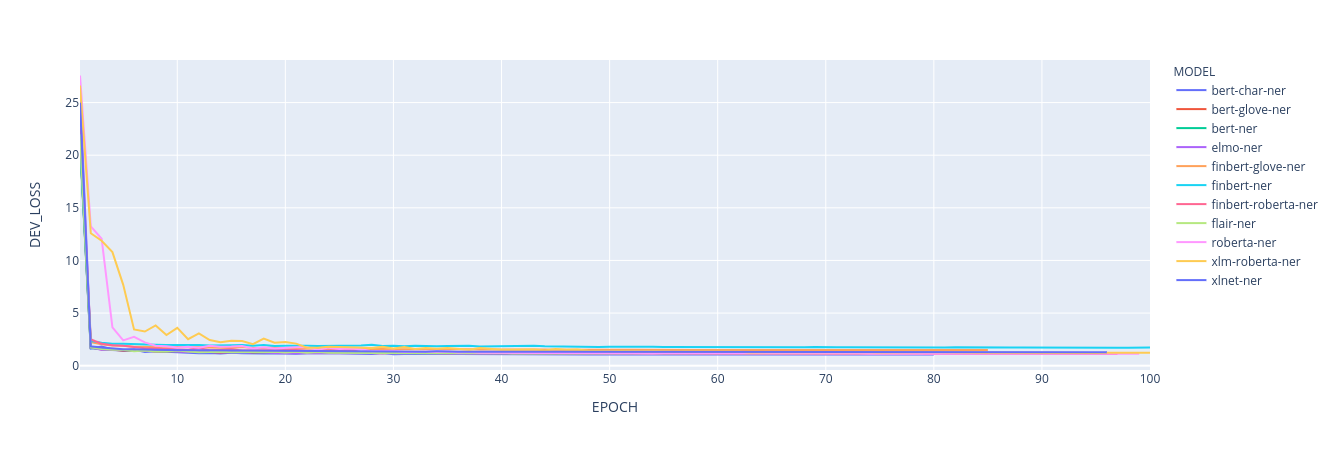

In [12]:
fig = px.line(loss, x="EPOCH", y="DEV_LOSS", color='MODEL')
pio.write_html(fig, file=str(Path('graphs') / 'valid_loss_onto_32.html'))
fig.show()

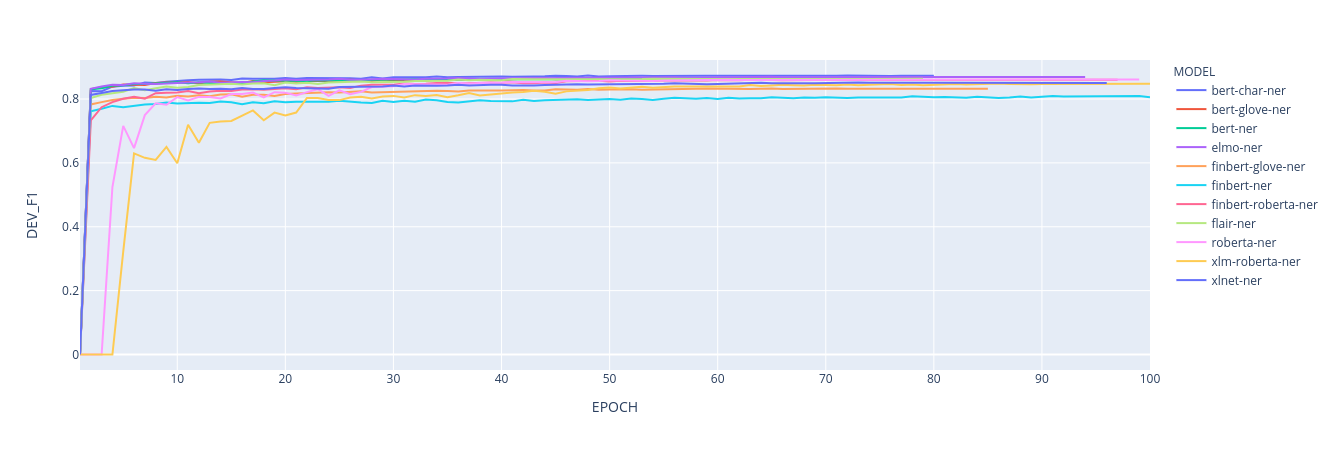

In [13]:
px.line(loss, x="EPOCH", y="DEV_F1", color='MODEL')

## SEC NER detection performance

In [14]:
SEC_RESULTS_DIR = Path('sec')
summary= pd.read_csv(SEC_RESULTS_DIR / 'summary.txt', sep='\t')

Check which models did not work, and exclude them from further analysis:

In [15]:
bad_performers = summary.loc[summary['F1-Macro'] < 0.1, 'Model']
bad_performers.tolist()

['finbert-char-ner', 'glove-char-ner']

In [16]:
summary = summary[~pd.isnull(summary['F1-Macro']) & (summary['F1-Macro'] > 0.1)]   # Skip bad performers
summary['Time'] = pd.to_datetime(summary['Ended']) - pd.to_datetime(summary['Started'])
summary['Time'] = np.round(summary['Time']/ np.timedelta64(1, 'm'), 1)
summary.sort_values(by='F1-Micro', ascending=False)

Model                  Started                    Ended  F1-Micro  \
5  roberta-ner  2021-04-12 23:13:42,272  2021-04-12 23:23:11,570    0.8206   
2  finbert-ner  2021-04-12 22:58:19,976  2021-04-12 23:06:04,991    0.8143   
7    xlnet-ner  2021-04-12 23:23:11,619  2021-04-12 23:31:01,871    0.8143   
3    flair-ner  2021-04-12 23:06:05,134  2021-04-12 23:12:52,549    0.7987   
0     elmo-ner  2021-04-12 23:05:36,980  2021-04-12 23:13:42,244    0.7857   

   F1-Macro  Time  
5    0.6360   9.5  
2    0.5800   7.8  
7    0.5293   7.8  
3    0.5275   6.8  
0    0.5982   8.1

In [17]:
perf = pd.read_csv(SEC_RESULTS_DIR / 'perf.txt', sep='\t', header=None)
perf.columns = ['Model', 'Type', 'Result']
perf[['TP', 'FP', 'FN', 'Precision', 'Recall', 'F1-Score']] = perf[['Result']].apply(extract_metrics, axis=1, result_type="expand")
perf = perf.drop(labels='Result', axis=1)
perf.loc[~perf['Model'].isin(bad_performers), ['Model', 'Type', 'Precision', 'F1-Score']].pivot(index='Type', columns='Model')

Precision                                             F1-Score  \
Model   elmo-ner finbert-ner flair-ner roberta-ner xlnet-ner elmo-ner   
Type                                                                    
LOC       0.5000      0.5217    0.7931      0.5208    0.5435   0.5476   
MISC      1.0000      1.0000    0.0000      1.0000    0.0000   0.4444   
ORG       0.3605      0.6042    0.4559      0.4684    0.5484   0.4397   
PERSON    0.9610      0.9159    0.9216      0.9614    0.9502   0.9610   

                                                    
Model  finbert-ner flair-ner roberta-ner xlnet-ner  
Type                                                
LOC         0.5714    0.6866      0.5814    0.5952  
MISC        0.2500    0.0000      0.4444    0.0000  
ORG         0.5631    0.5041      0.5522    0.5812  
PERSON      0.9356    0.9193      0.9660    0.9409

## Training performance (SEC)

In [18]:
loss = pd.read_csv(SEC_RESULTS_DIR / 'loss.txt', sep='\t')
loss = loss[~loss['MODEL'].isin(bad_performers)]

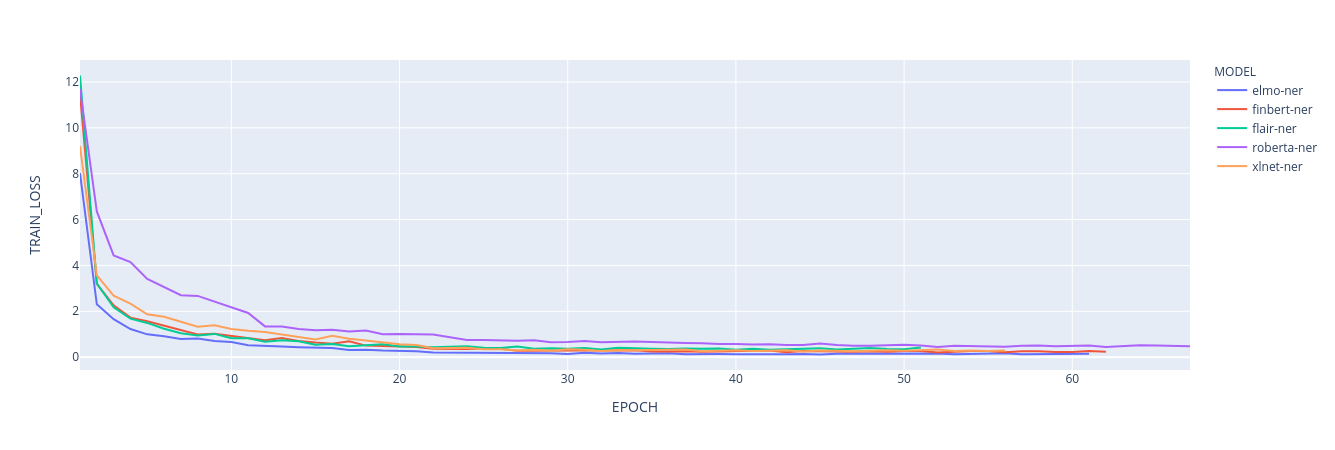

In [19]:
px.line(loss, x="EPOCH", y="TRAIN_LOSS", color='MODEL')

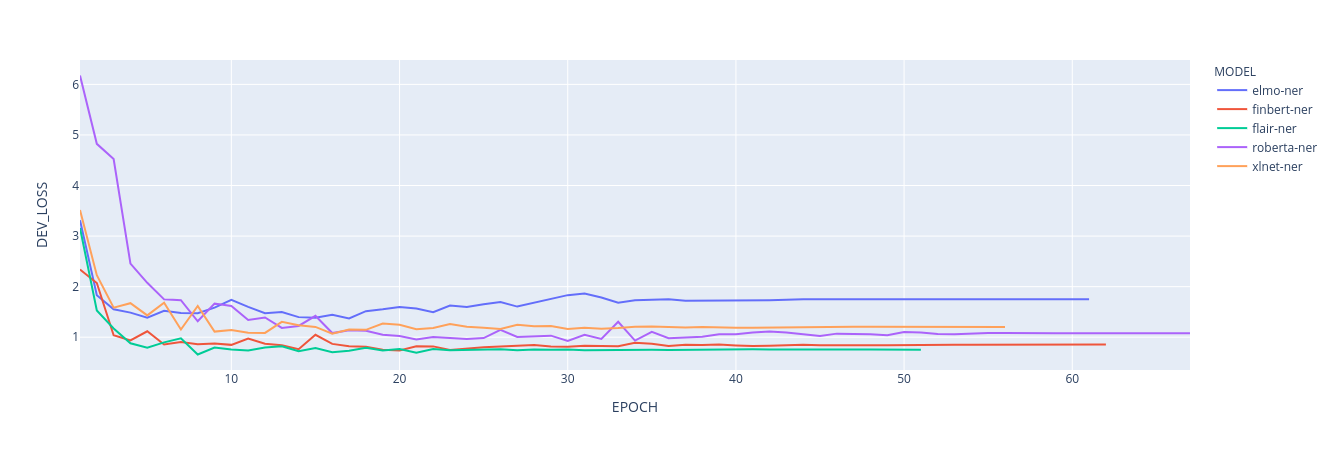

In [20]:
fig = px.line(loss, x="EPOCH", y="DEV_LOSS", color='MODEL')
pio.write_html(fig, file=str(Path('graphs') / 'valid_loss_sec_32.html'))
fig.show()

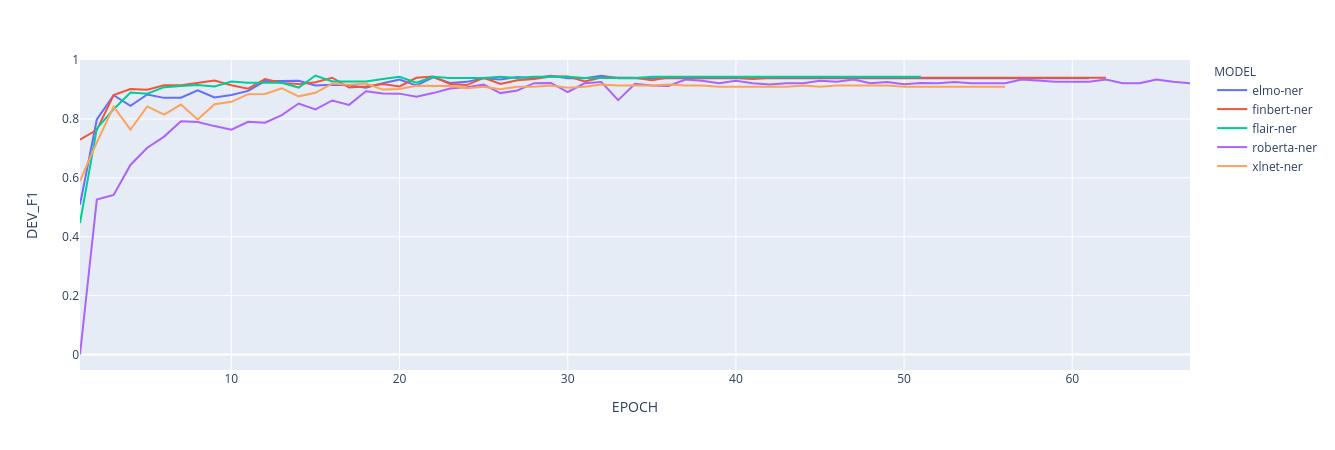

In [21]:
px.line(loss, x="EPOCH", y="DEV_F1", color='MODEL')